In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [57]:
#Preprocessing dataset
batch_size = 32
img_height = 180
img_width = 180
#Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'TLD_dataset-20201130T034909Z-001/TLD_dataset/training_set',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
#Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'TLD_dataset-20201130T034909Z-001/TLD_dataset/test_set',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 518 files belonging to 3 classes.
Using 415 files for training.
Found 121 files belonging to 3 classes.
Using 24 files for validation.
['green', 'red', 'yellow']


In [ ]:
"""
Performance tuning

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

"""

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

In [3]:
#Creating model

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3)
])

In [4]:
#Compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [58]:
#Training model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 6s 447ms/step - loss: 0.2732 - accuracy: 0.9012 - val_loss: 0.2613 - val_accuracy: 0.9583
Epoch 2/10
13/13 [==============================] - 6s 480ms/step - loss: 0.2477 - accuracy: 0.8916 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 3/10
13/13 [==============================] - 6s 440ms/step - loss: 0.2415 - accuracy: 0.9060 - val_loss: 0.2893 - val_accuracy: 0.9583
Epoch 4/10
13/13 [==============================] - 6s 437ms/step - loss: 0.2361 - accuracy: 0.9253 - val_loss: 0.1811 - val_accuracy: 0.9583
Epoch 5/10
13/13 [==============================] - 6s 449ms/step - loss: 0.1644 - accuracy: 0.9542 - val_loss: 0.1566 - val_accuracy: 0.9583
Epoch 6/10
13/13 [==============================] - 6s 434ms/step - loss: 0.1845 - accuracy: 0.9325 - val_loss: 0.2449 - val_accuracy: 0.9583
Epoch 7/10
13/13 [==============================] - 6s 454ms/step - loss: 0.1741 - accuracy: 0.9373 - val_loss: 0.2100 - val_accuracy: 0.9583
Epoch 

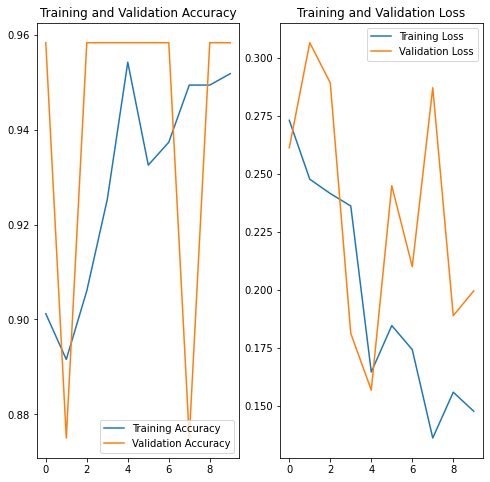

In [59]:
#Plot acc. vs loss for Training and Validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

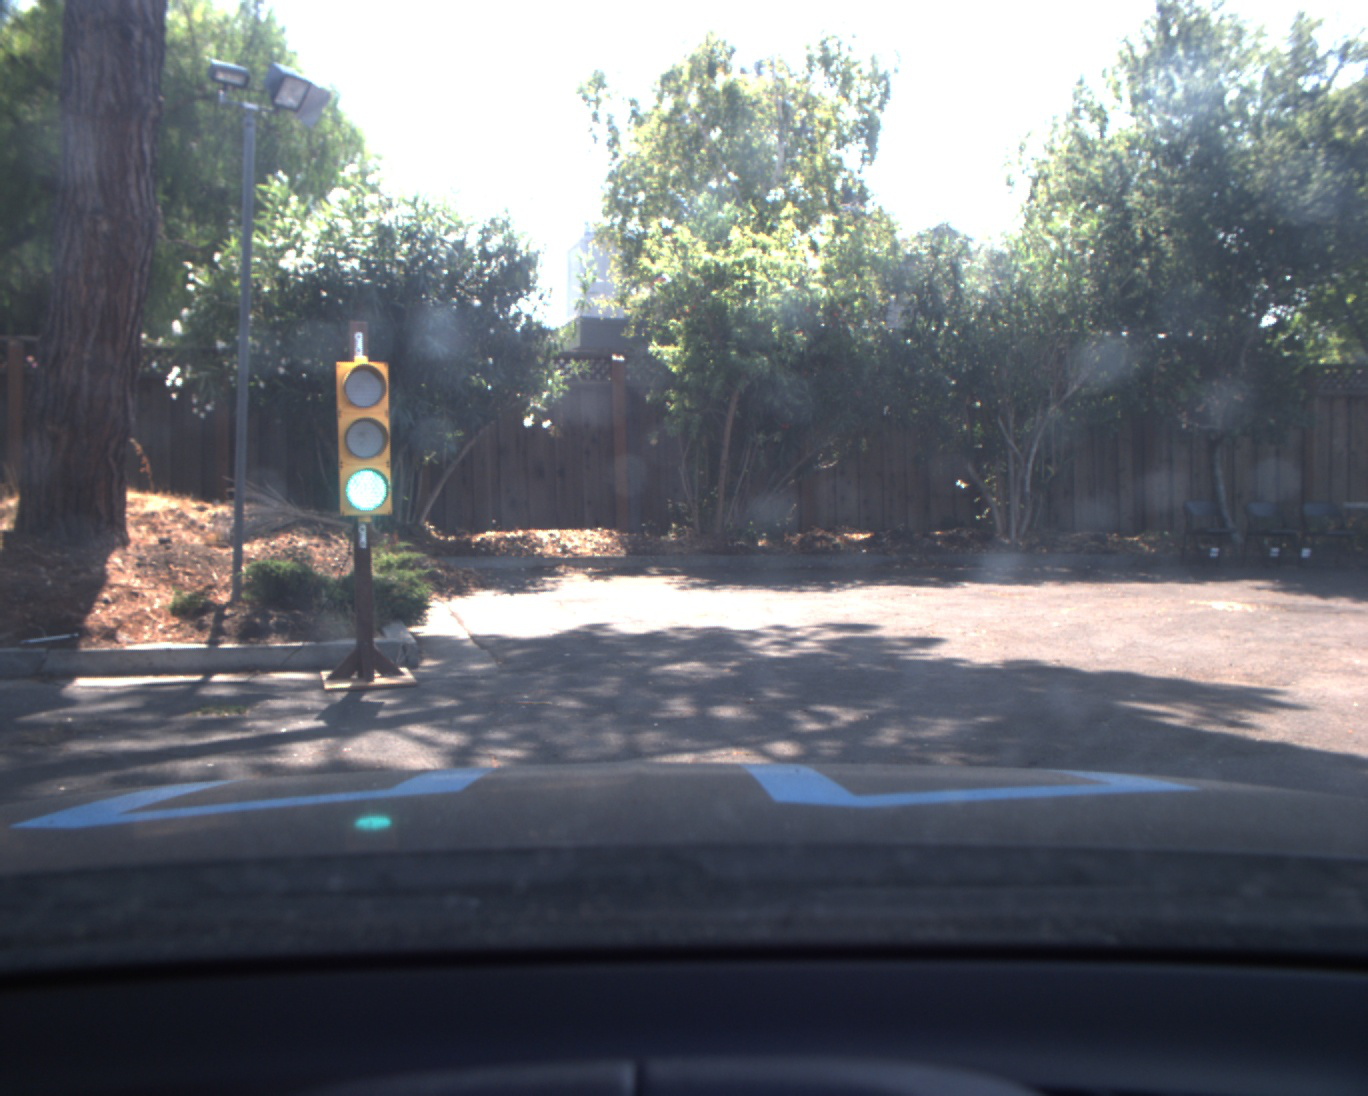

In [82]:
PIL.Image.open('TLD_dataset-20201130T034909Z-001/TLD_dataset/single_prediction/left1116.jpg')

In [83]:
#Predicting on images(green)
img = keras.preprocessing.image.load_img(
    'TLD_dataset-20201130T034909Z-001/TLD_dataset/single_prediction/left1116.jpg', target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print("\n This image is a {} signal with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([9.9958903e-01 1.4283399e-04 2.6815417e-04], shape=(3,), dtype=float32)

 This image is a green signal with a 99.96 percent confidence.


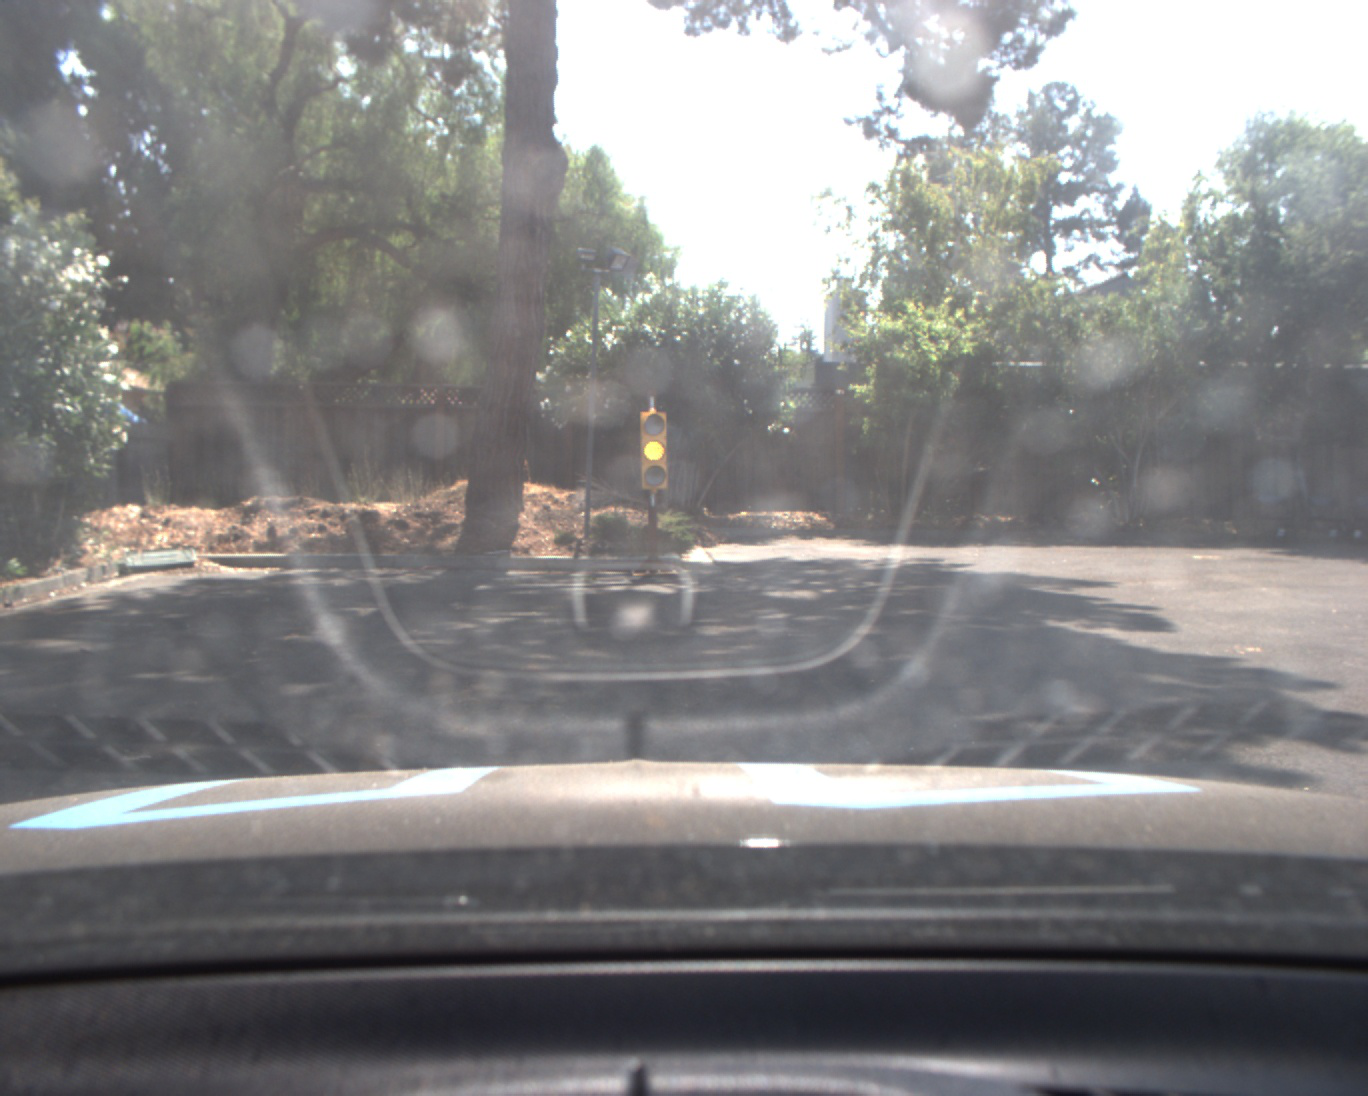

In [79]:
PIL.Image.open('TLD_dataset-20201130T034909Z-001/TLD_dataset/test_set/yellow/left0447.jpg')

In [81]:
#Predicting on images(yellow)
img = keras.preprocessing.image.load_img('TLD_dataset-20201130T034909Z-001/TLD_dataset/test_set/yellow/left0447.jpg', target_size=(img_height, img_width))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print("\n This image is a {} signal with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([0.00506766 0.10996415 0.88496816], shape=(3,), dtype=float32)

 This image is a yellow signal with a 88.50 percent confidence.


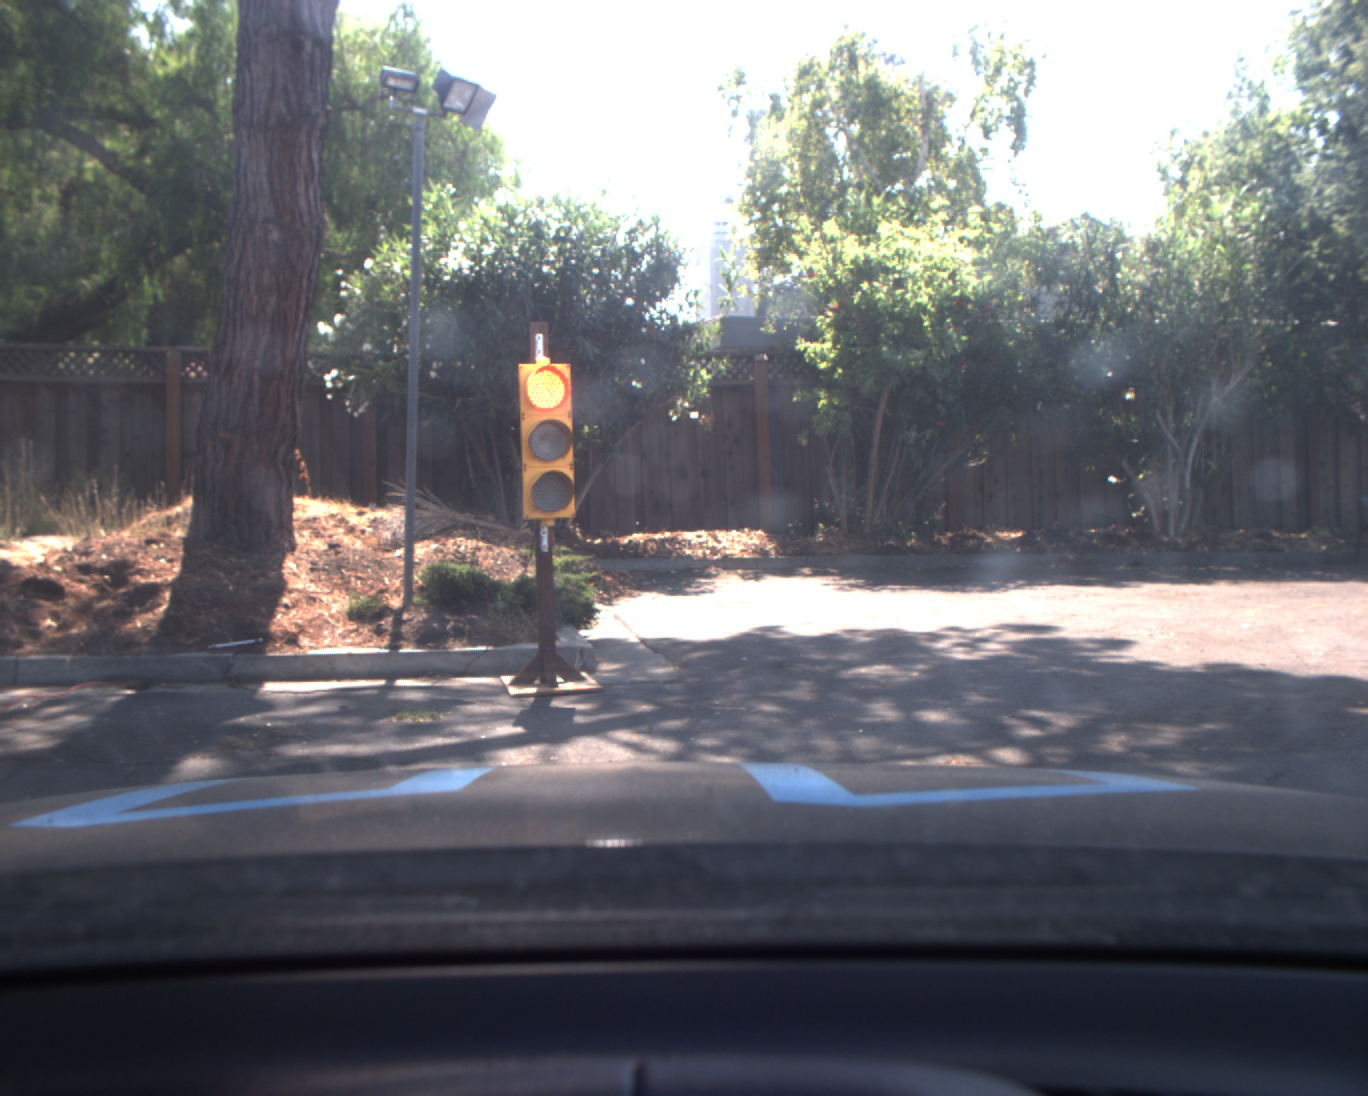

In [71]:
PIL.Image.open('TLD_dataset-20201130T034909Z-001/TLD_dataset/single_prediction/left0721.jpg')

In [72]:
#Predicting on images(red)
img = keras.preprocessing.image.load_img(
    'TLD_dataset-20201130T034909Z-001/TLD_dataset/single_prediction/left0721.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("\n This image is a {} signal with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


 This image is a red signal with a 89.34 percent confidence.
